In [249]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns
%matplotlib inline

from sklearn.naive_bayes import BernoulliNB

In [251]:
# Create a variable of the dataset URL
data_path = ('https://raw.githubusercontent.com/samfradkin/ThinkfulShare/master/amazon_cells_labelled.txt')

# Pull in the dataset, create column names, and get a preview of the data
amazon_raw = pd.read_csv(data_path, delimiter = '\t', header = None)
amazon_raw.columns = ['review', 'positive']

The Amazon Cell dataset is now imported. Let's see what it looks like.

In [252]:
amazon_raw.head()

,review,positive
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


It seems that negative words stand out more than positive ones so we need to make a list of negative words to find. In the __spam filter__ example, one of the steps was to include white space before and after each word in the search to make sure the word is found and it was not pulling words that are part of other words. Let's do just the opposite. To include words that might contain cotractions or another suffix, let's add white space to the keywords themselves in the proper places so we can treat each word or phrase differently.

In [253]:
negative_keywords = [' no way ', ' problem', ' static', ' waste', ' odd', ' mislead', ' poor', ' garbage ',
                     ' have to ', ' disappoint', ' hate', ' worthless ', ' return', ' do not ', ' wrong', ' advertis', 'flaw',
                    ' work', ' fail', ' forever ', ' literal']

In [254]:
# Run a for loop checking each review for the words in the negative_keywords array
for key in negative_keywords:
    amazon_raw[str(key)] = amazon_raw.review.str.contains(str(key), case = False)

The dataset we are dealing with was created with a binary column with a 1 indicating a positive review and 0 indicating a negative review. Being that we are looking for negative words, let's create a flipped binary column of the 'positive' column to indicate negative reviews, simply to cause less headaches.

In [255]:
amazon_raw['negative'] = (amazon_raw['positive'] == 0)

In [256]:
amazon_raw.head()

,review,positive,no way,problem,static,waste,odd,mislead,poor,garbage,...,return,do not,wrong,advertis,flaw,work,fail,forever,literal,negative
0,So there is no way for me to plug it in here i...,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,"Good case, Excellent value.",1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,The mic is great.,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


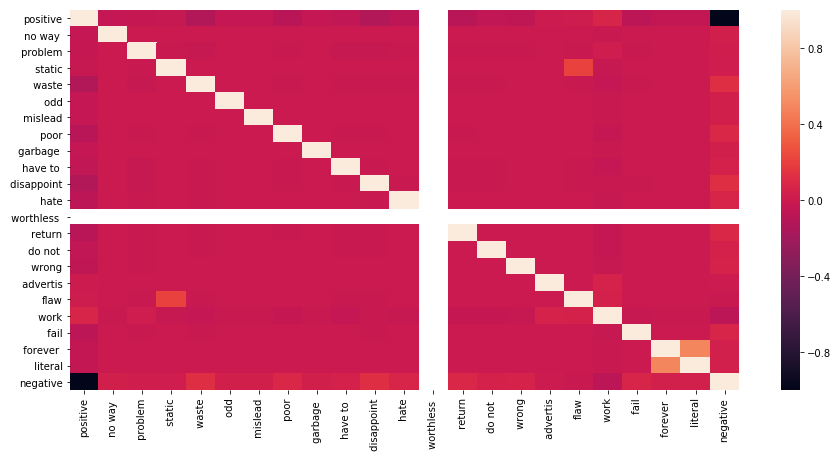

In [257]:
# Create a heatmap to see possible correlations between features.
plt.figure(figsize=(15,7))
sns.heatmap(amazon_raw.corr())
plt.show()

In [258]:
# Create the variables to run through the model
data = amazon_raw[negative_keywords]
target = amazon_raw['negative']

In [259]:
# Instantiate the model as a variable
bnb = BernoulliNB()

# Fit the model to the data
bnb.fit(data, target)

# Classify, storing the result in a new variable
y_pred = bnb.predict(data)

# Display the results
print("Number of mislabeled points: {}".format((target != y_pred).sum()))
print("Number of total points:     {}".format(data.shape[0]))

Number of mislabeled points: 420
Number of total points:     1000


In [260]:
print('_____ORIGINAL MODEL_____')
print('')

total_rows = data.shape[0]
incorrect = (target != y_pred).sum()
accuracy = (1 - (incorrect / total_rows)) * 100

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(target, y_pred)
print('----CONFUSION MATRIX----')
print(matrix)
print('')

sensitivity = (matrix[1][1]) / ((matrix[1][0]) + (matrix[1][1])) * 100
specificity = (matrix[0][0]) / ((matrix[0][0]) + (matrix[0][1])) * 100
accuracy = ((matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + 
                                             matrix[1][0] + matrix[1][1])) * 100

print('-----MODEL ACCURACY-----')
print("Sensitivity:       {}%".format(sensitivity.round(2)))
print("Specificity:       {}%".format(specificity.round(2)))
print("Overall Accuracy:  {}%". format(accuracy.round(2)))
print('')

# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(data, target).score(data, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, data, target, cv=10))
print(crossval)
print('Mean: ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv: ' + str((crossval.std() * 100).round(2)) + '%')

_____ORIGINAL MODEL_____

----CONFUSION MATRIX----
[[487  13]
 [407  93]]

-----MODEL ACCURACY-----
Sensitivity:       18.6%
Specificity:       97.4%
Overall Accuracy:  58.0%

-----USING HOLDOUT-----
With 20% Holdout:  61.5%
Testing on Sample: 58.0%

-----LEAVE ONE OUT-----
[0.62 0.6  0.6  0.55 0.6  0.5  0.54 0.55 0.56 0.59]
Mean: 57.1%
Stdv: 3.51%


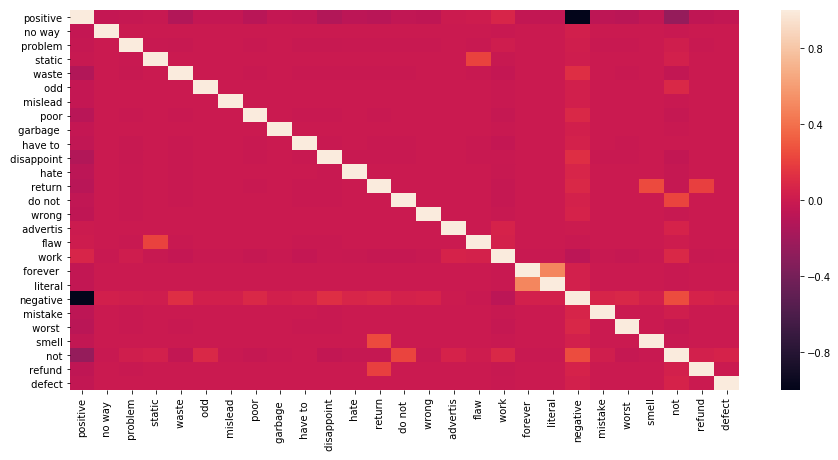

In [261]:
negative_keywords2 = [' mistake', ' worst ', ' smell', ' not', ' refund', ' defect']

# Run a for loop checking each review for the words in the negative_keywords array
for key in negative_keywords2:
    amazon_raw[str(key)] = amazon_raw.review.str.contains(str(key), case = False)

amazon_raw['negative'] = (amazon_raw['positive'] == 0)

amazon_raw.drop(columns=[' worthless ', ' fail'], inplace=True)

# Create a heatmap to see possible correlations between features.
plt.figure(figsize=(15,7))
sns.heatmap(amazon_raw.corr())
plt.show()

In [262]:
print('_________MODEL 2_________')
print('')

negative_keywords = negative_keywords + negative_keywords2
negative_keywords = [e for e in negative_keywords if e not in (' fail', ' worthless ')] 

data = amazon_raw[negative_keywords]
target = amazon_raw['negative']

bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points: {}".format((target != y_pred).sum()))
print("Number of total points:     {}".format(data.shape[0]))
print('')

total_rows = data.shape[0]
incorrect = (target != y_pred).sum()
accuracy = (1 - (incorrect / total_rows)) * 100

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(target, y_pred)
print('----CONFUSION MATRIX----')
print(matrix)
print('')

sensitivity = (matrix[1][1]) / ((matrix[1][0]) + (matrix[1][1])) * 100
specificity = (matrix[0][0]) / ((matrix[0][0]) + (matrix[0][1])) * 100
accuracy = ((matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + 
                                             matrix[1][0] + matrix[1][1])) * 100

print('-----MODEL ACCURACY-----')
print("Sensitivity:       {}%".format(sensitivity.round(2)))
print("Specificity:       {}%".format(specificity.round(2)))
print("Overall Accuracy:  {}%". format(accuracy.round(2)))
print('')

# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(data, target).score(data, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, data, target, cv=10))
print(crossval)
print('Mean:             ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv:             ' + str((crossval.std() * 100).round(2)) + '%')

_________MODEL 2_________

Number of mislabeled points: 341
Number of total points:     1000

----CONFUSION MATRIX----
[[476  24]
 [317 183]]

-----MODEL ACCURACY-----
Sensitivity:       36.6%
Specificity:       95.2%
Overall Accuracy:  65.9%

-----USING HOLDOUT-----
With 20% Holdout:  69.5%
Testing on Sample: 65.9%

-----LEAVE ONE OUT-----
[0.66 0.68 0.66 0.63 0.72 0.57 0.66 0.6  0.64 0.65]
Mean:             64.7%
Stdv:             3.93%


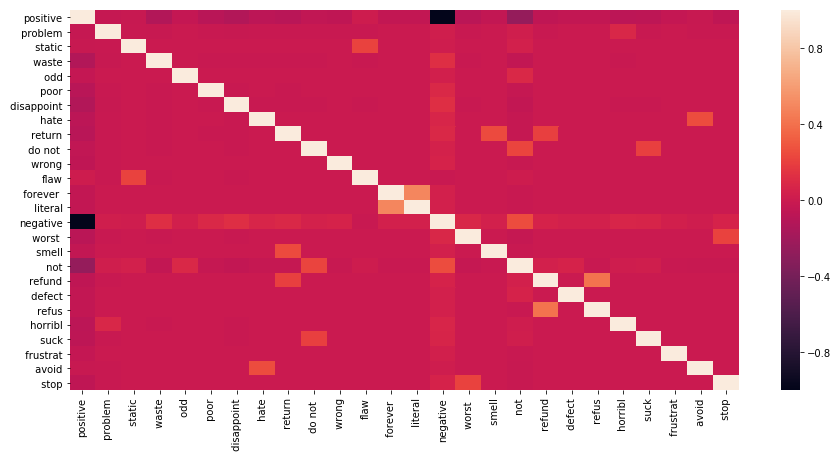

In [263]:
negative_keywords3 = [' refus', ' horribl', ' suck', ' frustrat', ' avoid', ' stop']

# Run a for loop checking each review for the words in the negative_keywords array
for key in negative_keywords3:
    amazon_raw[str(key)] = amazon_raw.review.str.contains(str(key), case = False)

amazon_raw['negative'] = (amazon_raw['positive'] == 0)

amazon_raw.drop(columns=[' work', ' advertis', ' no way ', ' mislead', ' garbage ', 
                         ' have to ', ' mistake'], inplace=True)

# Create a heatmap to see possible correlations between features.
plt.figure(figsize=(15,7))
sns.heatmap(amazon_raw.corr())
plt.show()

In [264]:
print('_________MODEL 3_________')
print('')

negative_keywords = negative_keywords + negative_keywords3
negative_keywords = [e for e in negative_keywords if e not in (' work', ' advertis', 
                                                               ' no way ', ' mislead', 
                                                               ' garbage ', ' have to ', 
                                                               ' mistake')] 

data = amazon_raw[negative_keywords]
target = amazon_raw['negative']

bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points: {}".format((target != y_pred).sum()))
print("Number of total points:     {}".format(data.shape[0]))
print('')

total_rows = data.shape[0]
incorrect = (target != y_pred).sum()
accuracy = (1 - (incorrect / total_rows)) * 100

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(target, y_pred)
print('----CONFUSION MATRIX----')
print(matrix)
print('')

sensitivity = (matrix[1][1]) / ((matrix[1][0]) + (matrix[1][1])) * 100
specificity = (matrix[0][0]) / ((matrix[0][0]) + (matrix[0][1])) * 100
accuracy = ((matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + 
                                             matrix[1][0] + matrix[1][1])) * 100

print('-----MODEL ACCURACY-----')
print("Sensitivity:       {}%".format(sensitivity.round(2)))
print("Specificity:       {}%".format(specificity.round(2)))
print("Overall Accuracy:  {}%". format(accuracy.round(2)))
print('')

# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(data, target).score(data, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, data, target, cv=10))
print(crossval)
print('Mean:              ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv:              ' + str((crossval.std() * 100).round(2)) + '%')

_________MODEL 3_________

Number of mislabeled points: 343
Number of total points:     1000

----CONFUSION MATRIX----
[[485  15]
 [328 172]]

-----MODEL ACCURACY-----
Sensitivity:       34.4%
Specificity:       97.0%
Overall Accuracy:  65.7%

-----USING HOLDOUT-----
With 20% Holdout:  68.5%
Testing on Sample: 65.7%

-----LEAVE ONE OUT-----
[0.64 0.67 0.67 0.66 0.72 0.58 0.63 0.62 0.65 0.64]
Mean:              64.8%
Stdv:              3.49%


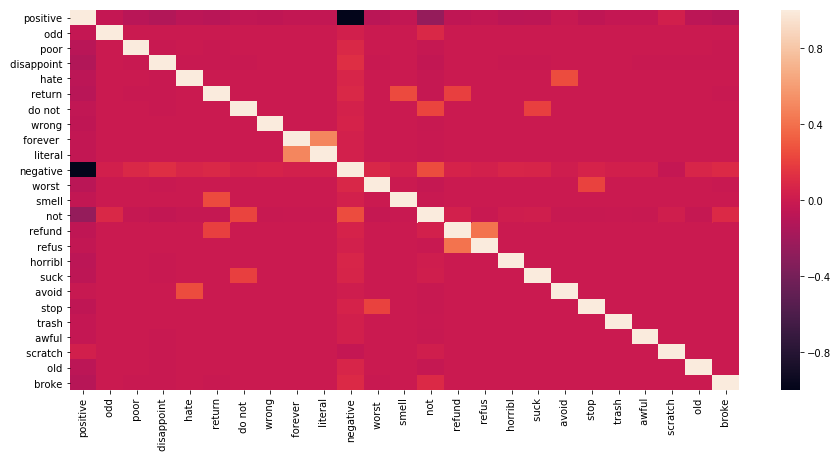

In [265]:
negative_keywords4 = [' trash', ' awful', ' scratch', ' old', ' broke']

# Run a for loop checking each review for the words in the negative_keywords array
for key in negative_keywords4:
    amazon_raw[str(key)] = amazon_raw.review.str.contains(str(key), case = False)

amazon_raw['negative'] = (amazon_raw['positive'] == 0)

amazon_raw.drop(columns=[' frustrat', ' defect', ' problem', ' static', ' waste', 'flaw'], 
                inplace=True)

# Create a heatmap to see possible correlations between features.
plt.figure(figsize=(15,7))
sns.heatmap(amazon_raw.corr())
plt.show()

In [266]:
print('_________MODEL 4_________')
print('')

negative_keywords = negative_keywords + negative_keywords4
negative_keywords = [e for e in negative_keywords if e not in (' frustrat', ' defect', 
                                                               ' problem', ' static', 
                                                               ' waste', 'flaw')] 

data = amazon_raw[negative_keywords]
target = amazon_raw['negative']

bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points: {}".format((target != y_pred).sum()))
print("Number of total points:     {}".format(data.shape[0]))
print('')

total_rows = data.shape[0]
incorrect = (target != y_pred).sum()
accuracy = (1 - (incorrect / total_rows)) * 100

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(target, y_pred)
print('----CONFUSION MATRIX----')
print(matrix)
print('')

sensitivity = (matrix[1][1]) / ((matrix[1][0]) + (matrix[1][1])) * 100
specificity = (matrix[0][0]) / ((matrix[0][0]) + (matrix[0][1])) * 100
accuracy = ((matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + 
                                             matrix[1][0] + matrix[1][1])) * 100

print('-----MODEL ACCURACY-----')
print("Sensitivity:       {}%".format(sensitivity.round(2)))
print("Specificity:       {}%".format(specificity.round(2)))
print("Overall Accuracy:  {}%". format(accuracy.round(2)))
print('')

# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(data, target).score(data, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, data, target, cv=10))
print(crossval)
print('Mean:              ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv:              ' + str((crossval.std() * 100).round(2)) + '%')

_________MODEL 4_________

Number of mislabeled points: 346
Number of total points:     1000

----CONFUSION MATRIX----
[[484  16]
 [330 170]]

-----MODEL ACCURACY-----
Sensitivity:       34.0%
Specificity:       96.8%
Overall Accuracy:  65.4%

-----USING HOLDOUT-----
With 20% Holdout:  68.0%
Testing on Sample: 65.4%

-----LEAVE ONE OUT-----
[0.62 0.65 0.64 0.66 0.72 0.61 0.63 0.67 0.65 0.64]
Mean:              64.9%
Stdv:              2.91%


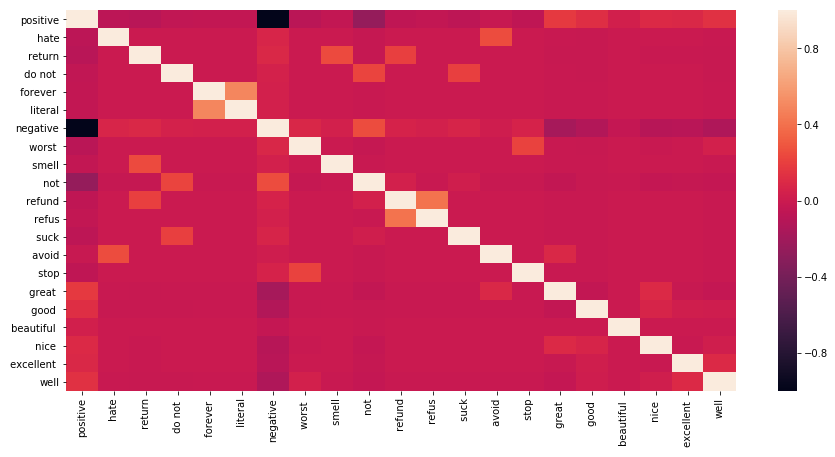

In [267]:
positive_keywords = [' great ', ' good ', ' beautiful ', ' nice ', ' excellent ', 'well']

# Run a for loop checking each review for the words in the negative_keywords array
for key in positive_keywords:
    amazon_raw[str(key)] = amazon_raw.review.str.contains(str(key), case = False)

amazon_raw['negative'] = (amazon_raw['positive'] == 0)

amazon_raw.drop(columns=[' odd', ' poor', ' disappoint', ' wrong', ' horribl', ' trash', 
                         ' awful', ' scratch', ' old', ' broke'], 
                inplace=True)

# Create a heatmap to see possible correlations between features.
plt.figure(figsize=(15,7))
sns.heatmap(amazon_raw.corr())
plt.show()

In [268]:
print('_________MODEL 5_________')
print('')

negative_keywords = negative_keywords + positive_keywords
negative_keywords = [e for e in negative_keywords if e not in (' odd', ' poor', 
                                                               ' disappoint', ' wrong', 
                                                               ' horribl', ' trash', 
                                                               ' awful', ' scratch', 
                                                               ' old', ' broke')] 

data = amazon_raw[negative_keywords]
target = amazon_raw['negative']

bnb.fit(data, target)
y_pred = bnb.predict(data)

print("Number of mislabeled points: {}".format((target != y_pred).sum()))
print("Number of total points:     {}".format(data.shape[0]))
print('')

total_rows = data.shape[0]
incorrect = (target != y_pred).sum()
accuracy = (1 - (incorrect / total_rows)) * 100

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(target, y_pred)
print('----CONFUSION MATRIX----')
print(matrix)
print('')

sensitivity = (matrix[1][1]) / ((matrix[1][0]) + (matrix[1][1])) * 100
specificity = (matrix[0][0]) / ((matrix[0][0]) + (matrix[0][1])) * 100
accuracy = ((matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + 
                                             matrix[1][0] + matrix[1][1])) * 100

print('-----MODEL ACCURACY-----')
print("Sensitivity:       {}%".format(sensitivity.round(2)))
print("Specificity:       {}%".format(specificity.round(2)))
print("Overall Accuracy:  {}%". format(accuracy.round(2)))
print('')

# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(data, target).score(data, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, data, target, cv=10))
print(crossval)
print('Mean:              ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv:              ' + str((crossval.std() * 100).round(2)) + '%')

_________MODEL 5_________

Number of mislabeled points: 390
Number of total points:     1000

----CONFUSION MATRIX----
[[486  14]
 [376 124]]

-----MODEL ACCURACY-----
Sensitivity:       24.8%
Specificity:       97.2%
Overall Accuracy:  61.0%

-----USING HOLDOUT-----
With 20% Holdout:  62.5%
Testing on Sample: 61.0%

-----LEAVE ONE OUT-----
[0.58 0.62 0.59 0.62 0.69 0.58 0.62 0.6  0.6  0.59]
Mean:              60.9%
Stdv:              3.08%
